In [1]:
import os
os.listdir("/kaggle/input/image-colorization-dataset")

['data']

In [2]:
from glob import glob

train_color = glob(
    "/kaggle/input/image-colorization-dataset/data/train_color/**/*.[jp][pn]g",
    recursive=True
)

train_black = glob(
    "/kaggle/input/image-colorization-dataset/data/train_black/**/*.[jp][pn]g",
    recursive=True
)

test_color = glob(
    "/kaggle/input/image-colorization-dataset/data/test_color/**/*.[jp][pn]g",
    recursive=True
)

test_black = glob(
    "/kaggle/input/image-colorization-dataset/data/test_black/**/*.[jp][pn]g",
    recursive=True
)

input train black, target train color

In [3]:
from sklearn.model_selection import train_test_split

val_color, test_color, val_black, test_black = train_test_split(
    test_color,
    test_black,
    test_size=0.5,     #50% test 50% val
    random_state=42,
    shuffle=True
)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import time

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
LR = 2e-5
EPOCHS = 50
PATIENCE = 15
MIN_DELTA = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class LabDataset(Dataset):
    def __init__(self, black_images, color_images, transform=None):
        self.black_images = black_images
        self.color_images = color_images
        self.transform = transform

    def __len__(self):
        return len(self.black_images)

    def __getitem__(self, idx):
        black = Image.open(self.black_images[idx]).convert("L")
        color = Image.open(self.color_images[idx]).convert("RGB")

        if self.transform:
            black = self.transform(black)
            color = self.transform(color)

        #RGBto LAB
        color = np.array(color)
        lab = rgb2lab(color).astype("float32")

        L  = lab[:, :, 0] / 50.0 - 1.0        # [-1,1]
        ab = lab[:, :, 1:] / 110.0            # [-1,1]

        L  = torch.from_numpy(L).unsqueeze(0)
        ab = torch.from_numpy(ab).permute(2,0,1)

        return L, ab

In [7]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
])

In [8]:
train_dataset = LabDataset(
    black_images=train_black,
    color_images=train_color,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

In [9]:
test_dataset = LabDataset(
    black_images=test_black,
    color_images=test_color,
    transform=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False
)

In [10]:
val_dataset = LabDataset(
    black_images=val_black,
    color_images=val_color,
    transform=transform
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [11]:
print('Training Set: ', len(train_dataset))
print('Validation Set: ', len(val_dataset))
print('Test Set: ', len(test_dataset))

Training Set:  5000
Validation Set:  369
Test Set:  370


psnr (peak signal to noise ratio) -> ngukur sbrp mirip hasil gambar model dgn gmbr asli scr angka piksel (salah dikit -> psnr tinggi, salah banyak -> psnr rendah

ssim (structural similarity index) -> sbrp mirip struktural visual gmbr hasil model dengan gambar asli mnurut pov human

In [12]:
def lab_to_rgb(L, ab):
    if L.max() <= 1.0:
        L = L * 100.0

    if np.abs(ab).max() <= 1.0:
        ab = ab * 128.0

    lab = np.zeros((L.shape[0], L.shape[1], 3))
    lab[:, :, 0] = L
    lab[:, :, 1:] = ab

    # lab to rgb
    rgb = lab2rgb(lab)

    return np.clip(rgb, 0, 1)

In [13]:
def compute_metrics(model, dataset, n_samples=50):
    model.eval()
    psnr_list, ssim_list = [], []

    for i in range(n_samples):
        with torch.no_grad():
            L, ab = dataset[i]

            if L.dim() == 3:        # [1,H,W]
                L = L.unsqueeze(0)  # [B,1,H,W]

            L = L.to(device)
            pred_ab = model(L)      # [B,2,H,W]

        L_img = L[0,0].cpu().numpy()   # [H,W]

        if ab.dim() == 4:              # [B,2,H,W]
            ab_gt = ab[0].permute(1,2,0).cpu().numpy()
        elif ab.dim() == 3:            # [2,H,W]
            ab_gt = ab.permute(1,2,0).cpu().numpy()
        else:                          # [H,W,2]
            ab_gt = ab.cpu().numpy()
            
        ab_pred = pred_ab[0].permute(1,2,0).cpu().numpy()

        gt_rgb   = lab_to_rgb(L_img, ab_gt)
        pred_rgb = lab_to_rgb(L_img, ab_pred)

        psnr_val = psnr(gt_rgb, pred_rgb, data_range=1.0)
        ssim_val = ssim(gt_rgb, pred_rgb, channel_axis=2, data_range=1.0)

        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)

    return psnr_list, ssim_list

In [14]:
def plot_results(model, dataset, start_idx=1, num_samples=5):
    model.eval()
    plt.figure(figsize=(18, num_samples * 4))

    vmax = 0.3

    for i in range(num_samples):
        L, ab = dataset[start_idx + i]

        if L.dim() == 3:          # [1,H,W]
            L = L.unsqueeze(0)    # [B,1,H,W]

        L = L.to(device)

        with torch.no_grad():
            pred_ab = model(L)

        
        L_img = L[0, 0].cpu().numpy()                     # BnW
        ab_gt = ab.permute(1, 2, 0).cpu().numpy()         # GT ab
        ab_pd = pred_ab[0].permute(1, 2, 0).cpu().numpy() # Pred ab

        gt_rgb   = lab_to_rgb(L_img, ab_gt)
        pred_rgb = lab_to_rgb(L_img, ab_pd)

        error_map = np.mean(np.abs(gt_rgb - pred_rgb), axis=2)

        row = i * 4

        #bnw input
        plt.subplot(num_samples, 4, row + 1)
        plt.imshow(L_img, cmap="gray")
        plt.title("Input (BnW)")
        plt.axis("off")

        # ground truth
        plt.subplot(num_samples, 4, row + 2)
        plt.imshow(gt_rgb)
        plt.title("Ground Truth")
        plt.axis("off")

        # prediksi
        plt.subplot(num_samples, 4, row + 3)
        plt.imshow(pred_rgb)
        plt.title("Predicted")
        plt.axis("off")

        # error map
        ax = plt.subplot(num_samples, 4, row + 4)
        im = ax.imshow(error_map, cmap="hot", vmin=0, vmax=vmax)
        ax.set_title(f"Error Map\nMean: {error_map.mean():.4f}")
        ax.axis("off")

        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("Pixel Error")

    plt.tight_layout()
    plt.show()

In [15]:
def train_model(model, save_path):
    best_val_loss = float("inf")
    counter = 0
    best_epoch = 0

    train_losses = []
    val_losses = []

    print("Start training...")
    for epoch in range(EPOCHS):
        # ===== TRAIN =====
        model.train()
        running_train_loss = 0.0

        for input_l, target_ab in train_loader:
            input_l = input_l.to(device)
            target_ab = target_ab.to(device)

            output_ab = model(input_l)
            loss = criterion(output_ab, target_ab)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ===== VALIDATION =====
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for input_l, target_ab in val_loader:
                input_l = input_l.to(device)
                target_ab = target_ab.to(device)

                output_ab = model(input_l)
                loss = criterion(output_ab, target_ab)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        #earlystop
        if avg_val_loss < best_val_loss - MIN_DELTA:
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            counter = 0

            torch.save({
                "epoch": best_epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_loss": best_val_loss
            }, save_path)
        else:
            counter += 1

        print(
            f"Epoch [{epoch+1}/{EPOCHS}] | "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | "
            f"ES Counter: {counter}/{PATIENCE}"
        )

        if counter >= PATIENCE:
            print("Early stopping triggered.")
            break

    print("Training finished.")
    print(f"Best model at epoch {best_epoch} with val loss {best_val_loss:.4f}")

    return train_losses, val_losses, best_epoch, best_val_loss

In [16]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def compute_metrics(model, dataset):
    model.eval()
    psnr_list, ssim_list = [], []

    for i in range(len(dataset)):
        with torch.no_grad():
            L, ab = dataset[i]

            # pastikan L ada batch dim
            if L.dim() == 3:        # [1,H,W]
                L = L.unsqueeze(0)  # [B,1,H,W]

            L = L.to(device)
            pred_ab = model(L)      # [B,2,H,W]

        # =======================
        # Handle L
        # =======================
        L_img = L[0,0].cpu().numpy()   # [H,W]

        # =======================
        # Handle GT ab
        # =======================
        if ab.dim() == 4:              # [B,2,H,W]
            ab_gt = ab[0].permute(1,2,0).cpu().numpy()
        elif ab.dim() == 3:            # [2,H,W]
            ab_gt = ab.permute(1,2,0).cpu().numpy()
        else:                          # [H,W,2]
            ab_gt = ab.cpu().numpy()

        # =======================
        # Predicted ab
        # =======================
        ab_pred = pred_ab[0].permute(1,2,0).cpu().numpy()

        # =======================
        # LAB → RGB
        # =======================
        gt_rgb   = lab_to_rgb(L_img, ab_gt)
        pred_rgb = lab_to_rgb(L_img, ab_pred)

        # =======================
        # Metrics
        # =======================
        psnr_val = psnr(gt_rgb, pred_rgb, data_range=1.0)
        ssim_val = ssim(gt_rgb, pred_rgb, channel_axis=2, data_range=1.0)

        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)

    return psnr_list, ssim_list

In [17]:
def plot_psnr_ssim_distribution(psnr_list, ssim_list, model_name="Model"):
    psnr = np.array(psnr_list)
    ssim = np.array(ssim_list)

    plt.figure(figsize=(12,5))

    # ===== PSNR Scatter =====
    plt.subplot(1,2,1)
    plt.scatter(range(len(psnr)), psnr)
    plt.axhline(psnr.mean(), linestyle='--', label=f"Mean PSNR = {psnr.mean():.2f}")
    plt.xlabel("Image Index")
    plt.ylabel("PSNR")
    plt.title(f"{model_name} PSNR Distribution")
    plt.legend()

    # ===== SSIM Scatter =====
    plt.subplot(1,2,2)
    plt.scatter(range(len(ssim)), ssim)
    plt.axhline(ssim.mean(), linestyle='--', label=f"Mean SSIM = {ssim.mean():.3f}")
    plt.xlabel("Image Index")
    plt.ylabel("SSIM")
    plt.title(f"{model_name} SSIM Distribution")
    plt.legend()

    plt.tight_layout()
    plt.show()

## **RESNET UNET**

In [21]:
class resnet_unet(nn.Module):
    def __init__(self):
        super(resnet_unet, self).__init__()

        # Encoder: ResNet18 Pretrained
        resnet = models.resnet18(pretrained=True)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.encoder1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.encoder2 = resnet.layer1
        self.encoder3 = resnet.layer2
        self.encoder4 = resnet.layer3
        self.encoder5 = resnet.layer4

        # Decoder
        self.decoder4 = self._block(512, 256)
        self.decoder3 = self._block(256 + 256, 128)
        self.decoder2 = self._block(128 + 128, 64)
        self.decoder1 = self._block(64 + 64, 32)

        self.final = nn.Conv2d(32, 2, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def _block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, 1, 1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)

        d4 = self.decoder4(e5)
        d3 = self.decoder3(torch.cat([d4, e4], dim=1))
        d2 = self.decoder2(torch.cat([d3, e3], dim=1))
        d1 = self.decoder1(torch.cat([d2, e2], dim=1))

        out = self.final(d1)
        out = self.upsample(out)

        return out

In [22]:
model_resnet_unet = resnet_unet().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model_resnet_unet.parameters(), lr=LR)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


In [23]:
train_losses, val_losses, best_epoch, best_val_loss = train_model(model_resnet_unet, "resnet_unet.pth")

Start training...
Epoch [1/50] | Train Loss: 0.1310 | Val Loss: 0.0948 | ES Counter: 0/15
Epoch [2/50] | Train Loss: 0.0900 | Val Loss: 0.0868 | ES Counter: 0/15
Epoch [3/50] | Train Loss: 0.0852 | Val Loss: 0.0841 | ES Counter: 0/15
Epoch [4/50] | Train Loss: 0.0827 | Val Loss: 0.0824 | ES Counter: 0/15
Epoch [5/50] | Train Loss: 0.0811 | Val Loss: 0.0827 | ES Counter: 1/15
Epoch [6/50] | Train Loss: 0.0797 | Val Loss: 0.0807 | ES Counter: 0/15
Epoch [7/50] | Train Loss: 0.0781 | Val Loss: 0.0810 | ES Counter: 1/15
Epoch [8/50] | Train Loss: 0.0768 | Val Loss: 0.0802 | ES Counter: 0/15
Epoch [9/50] | Train Loss: 0.0750 | Val Loss: 0.0819 | ES Counter: 1/15
Epoch [10/50] | Train Loss: 0.0734 | Val Loss: 0.0810 | ES Counter: 2/15
Epoch [11/50] | Train Loss: 0.0718 | Val Loss: 0.0815 | ES Counter: 3/15
Epoch [12/50] | Train Loss: 0.0701 | Val Loss: 0.0815 | ES Counter: 4/15
Epoch [13/50] | Train Loss: 0.0691 | Val Loss: 0.0800 | ES Counter: 0/15
Epoch [14/50] | Train Loss: 0.0678 | Val L

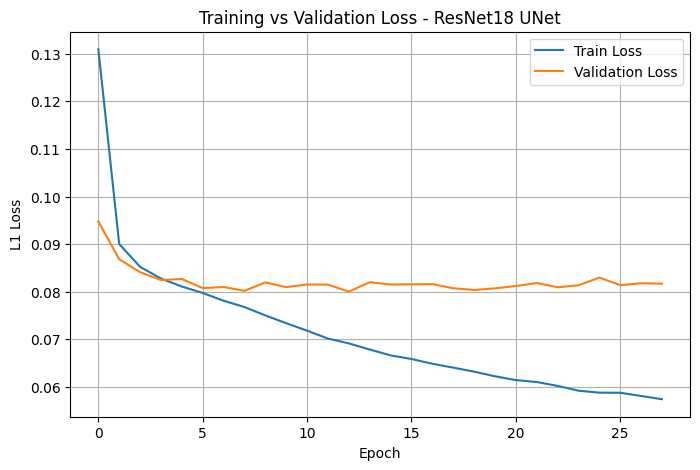

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("L1 Loss")
plt.title("Training vs Validation Loss - ResNet18 UNet")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_47/1358663669.py:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3120 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab)
/tmp/ipykernel_47/1358663669.py:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3123 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab)
/tmp/ipykernel_47/1358663669.py:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 20165 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab)
/tmp/ipykernel_47/1358663669.py:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7677 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab)
/tmp/ipykernel_47/1358663669.py:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 34102 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab)
/tmp/ipykernel_47/1358663669.py:13: UserWarning: Conv

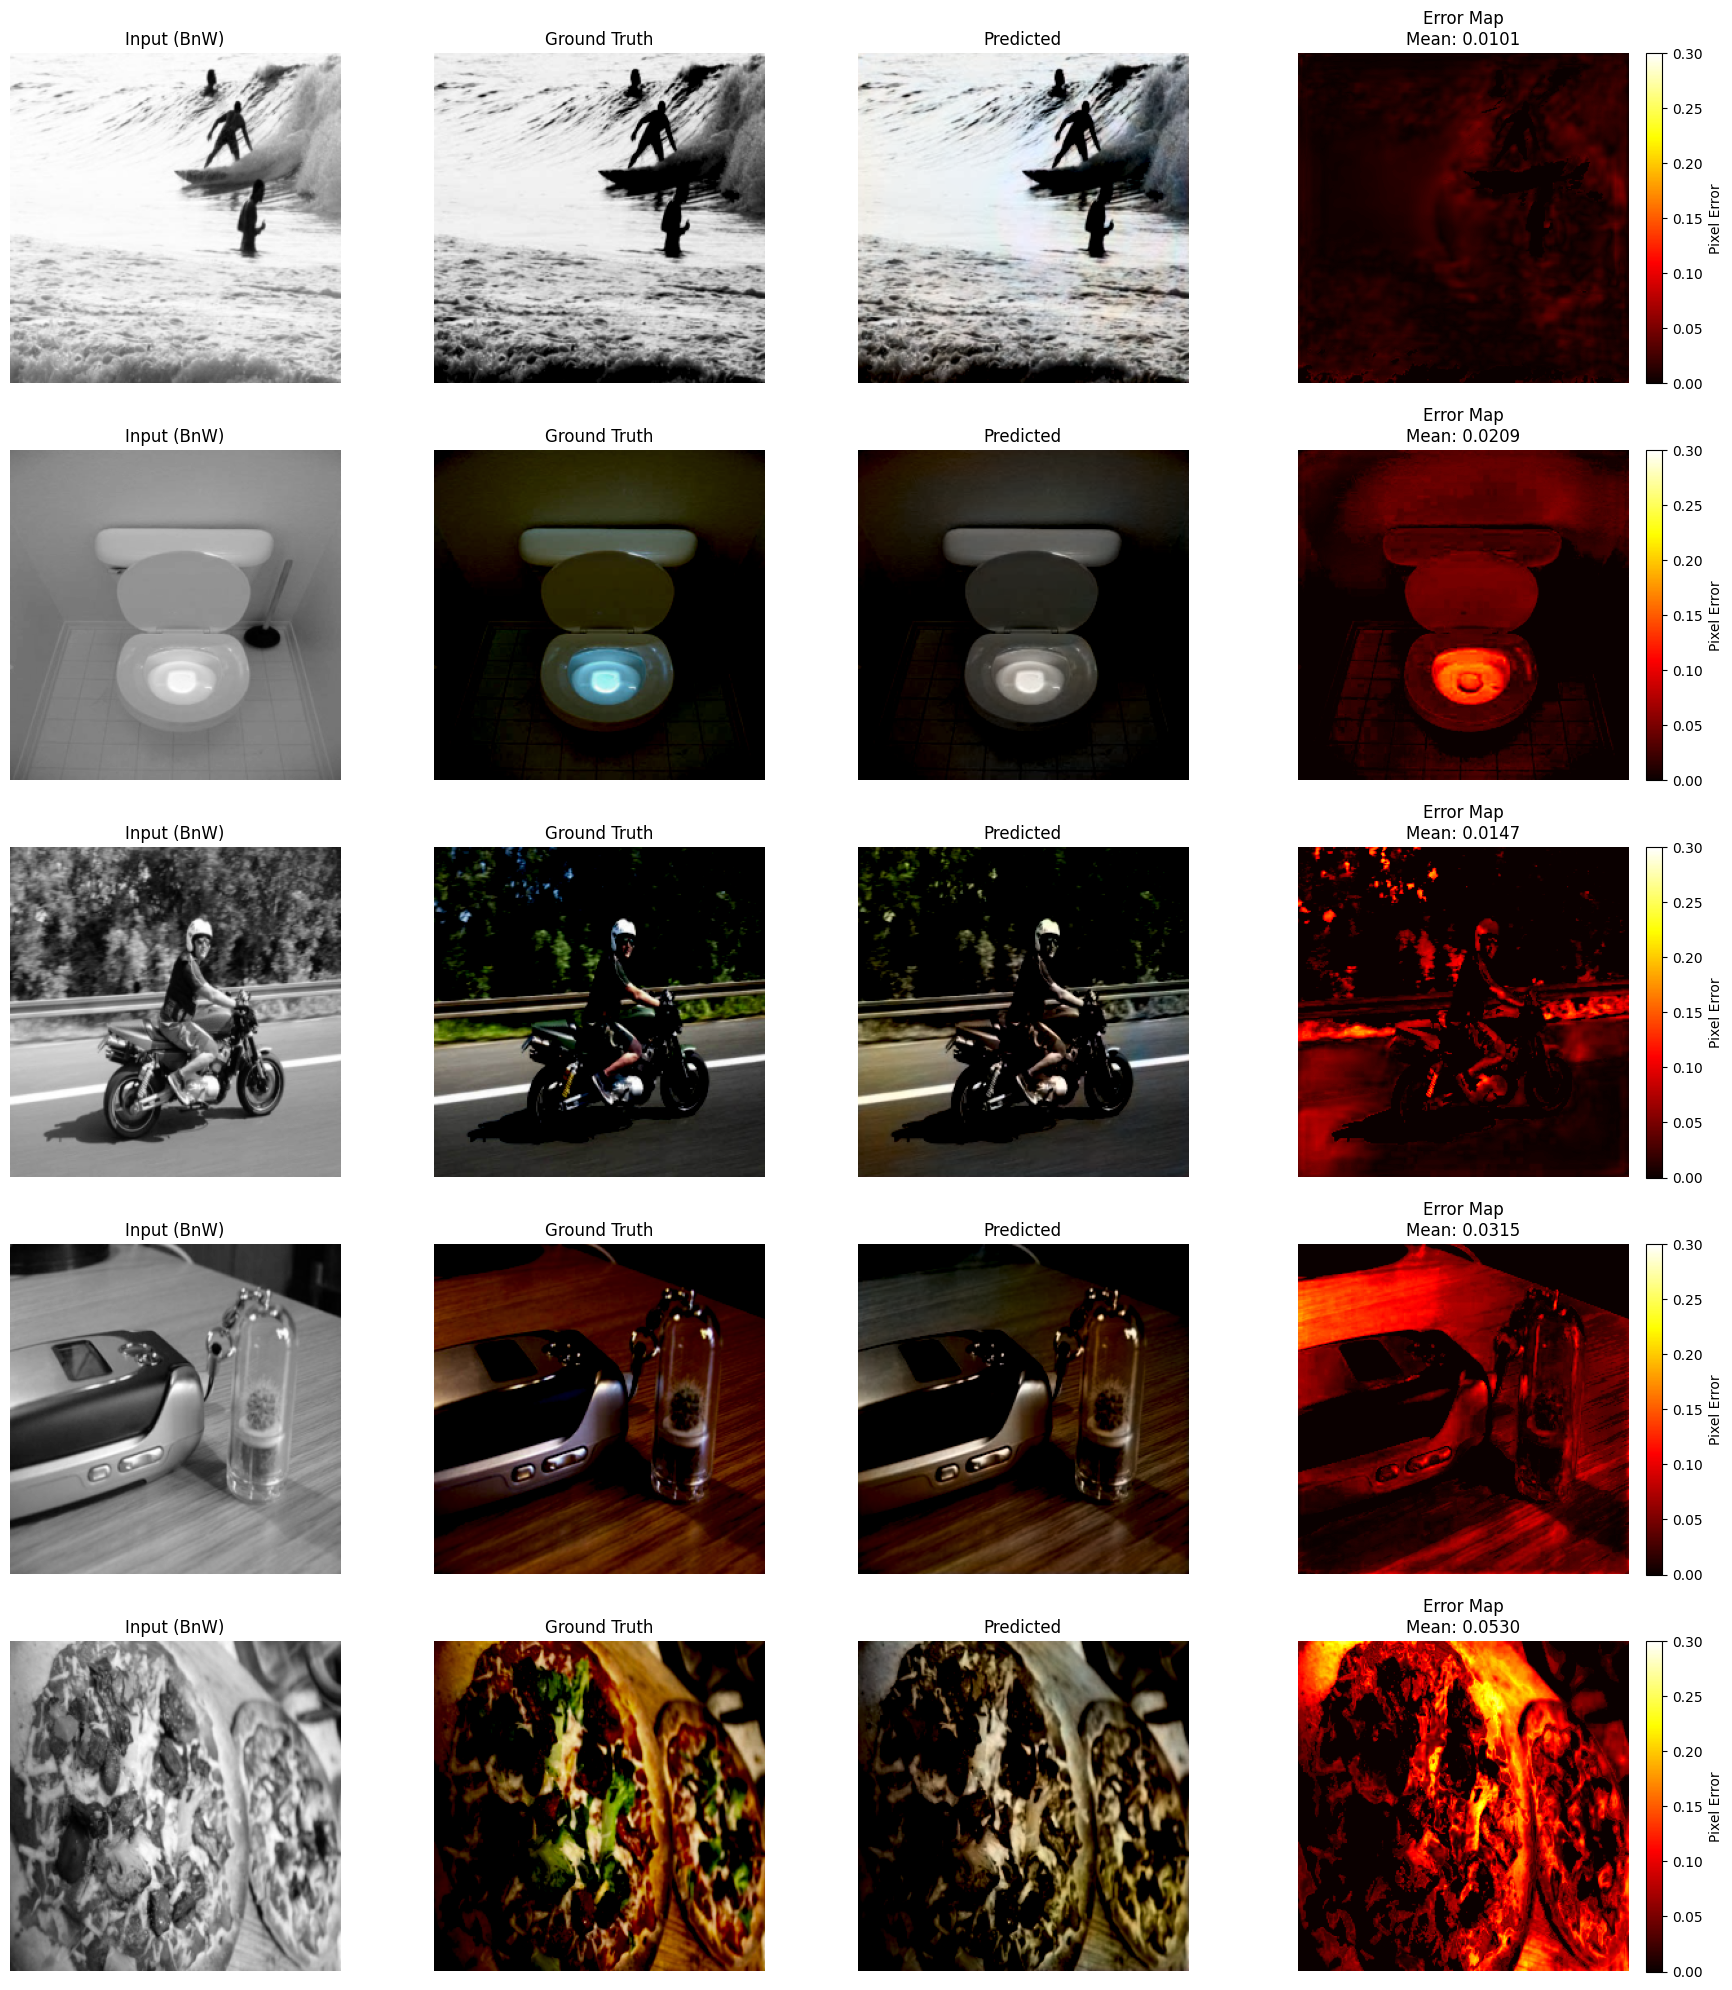

In [25]:
plot_results(model_resnet_unet, test_dataset, 23)

/tmp/ipykernel_47/1358663669.py:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 55535 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab)
/tmp/ipykernel_47/1358663669.py:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 51847 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab)
/tmp/ipykernel_47/1358663669.py:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 33398 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab)
/tmp/ipykernel_47/1358663669.py:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 34486 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab)
/tmp/ipykernel_47/1358663669.py:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4299 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab)
/tmp/ipykernel_47/1358663669.py:13: UserWarning: Co

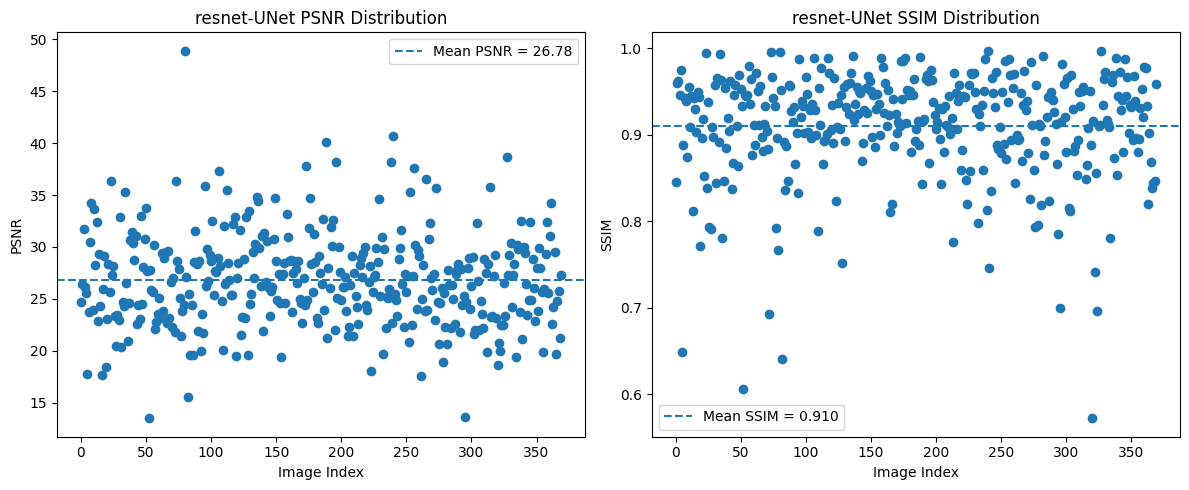

In [26]:
psnr_list, ssim_list = compute_metrics(model_resnet_unet, test_dataset)
plot_psnr_ssim_distribution(psnr_list, ssim_list, "resnet-UNet")